# Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Initialise GPU

In [2]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data Loading and Pre-processing

In [3]:
# Class for pre-processing the data
class MIMICDataProcessor:
    def __init__(self, file_path, batch_size=64):
        self.file_path = file_path
        self.batch_size = batch_size
        self.scaler = StandardScaler()

        # Load and preprocess the data
        self.df = pd.read_csv(file_path)
        # Replace all missing values with 0
        self.df.fillna(0, inplace=True)

        # Features
        self.X = self.df[['upper_respiratory_infections', 'influenza_pneumonia', 'acute_lower_respiratory_infections', 'chronic_lower_respiratory_diseases',
                          'lung_diseases_due_to_external_agents', 'other_respiratory_diseases', 'InvasiveVent', 'SupplementalOxygen', 'HFNC',
                          'NonInvasiveVent', 'Tracheostomy', 'None', 'avg_uo_24hr', 'avg_creatinine_max', 'max_renal_uo_24hr', 'max_renal_creatinine_max',
                          'avg_pao2fio2ratio_novent', 'avg_pao2fio2ratio_vent', 'max_respiration_pao2fio2ratio_novent', 'max_respiration_pao2fio2ratio_vent', 'avg_gcs_min', 'max_cns_gcs_min',
                          'sofa_score', 'suspected_infection', 'one_vasopressor', 'multi_vasopressor']]

        # Concepts
        self.C = self.df[['c_rsp_mod', 'c_rsp_svr', 'c_vent_low', 'c_vent_moderate', 'c_vent_high', 'c_max_renf_moderate', 'c_max_renf_severe',
                          'c_avg_renf_moderate', 'c_avg_renf_severe', 'c_max_respf_moderate', 'c_max_respf_severe', 'c_avg_respf_moderate',
                          'c_avg_respf_severe', 'c_max_cnsf_moderate', 'c_max_cnsf_severe', 'c_avg_cnsf_moderate', 'c_avg_cnsf_severe',
                          'c_sepsis3', 'c_shock']]

        # Label
        self.Y = self.df['ARDS']


        # Convert to tensors
        self.X_tensor = torch.tensor(self.X.values, dtype=torch.float32)
        self.C_tensor = torch.tensor(self.C.values, dtype=torch.float32)
        self.Y_tensor = torch.tensor(self.Y.values, dtype=torch.float32)

        # Normalize the features
        self.X_scaled = self.scaler.fit_transform(self.X)
        self.X_tensor_scaled = torch.tensor(self.X_scaled, dtype=torch.float32)

    def get_features(self):
        return self.X.columns.tolist()

    def get_concepts(self):
        return self.C.columns.tolist()

    def get_labels(self):
        return self.Y.columns.tolist()

    # Dataset class needed to provide the __getitem__ method for DataLoader
    class MIMICDataset(Dataset):
        def __init__(self, x, c, y):
            self.x = x
            self.c = c
            self.y = y

        def __len__(self):
            return len(self.y)

        def __getitem__(self, idx):
            return self.x[idx], self.c[idx], self.y[idx]

    def create_dataloaders(self):
        # Split the data into temporary (80%) and test (20%) sets
        X_temp, X_test, C_temp, C_test, Y_temp, Y_test = train_test_split(
            self.X_tensor_scaled, self.C_tensor, self.Y_tensor, test_size=0.20, random_state=42)

        # Further split the temporary data into training (75% of temporary) and validation (25% of temporary) sets
        X_train, X_val, C_train, C_val, Y_train, Y_val = train_test_split(
            X_temp, C_temp, Y_temp, test_size=0.25, random_state=42)

        train_dataset = self.MIMICDataset(X_train, C_train, Y_train)
        val_dataset = self.MIMICDataset(X_val, C_val, Y_val)
        test_dataset = self.MIMICDataset(X_test, C_test, Y_test)

        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)

        return train_loader, val_loader, test_loader

# Model

In [4]:
class MultiLabelNN(nn.Module):
    def __init__(self, num_features, num_labels):
        super(MultiLabelNN, self).__init__()
        self.layer1 = nn.Linear(num_features, 32)
        self.layer2 = nn.Linear(32, 64)
        self.output_layer = nn.Linear(64, num_labels)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.sigmoid(self.output_layer(x))  # Sigmoid activation to output probabilities for each label
        return x

# Training

Look at the Step 5 from this [basic code](https://colab.research.google.com/drive/1LqE89tPVt6h1wa7lerLgF4GNvRw9QFDw?usp=sharing) for reference.

In [5]:
def train(x_size, c_size, y_size, x_to_c_learning_rate, c_to_y_learning_rate, weight_decay, epochs, train_loader, val_loader):
    torch.manual_seed(25)

    x_to_c = MultiLabelNN(num_features=x_size, num_labels=c_size).to(device)
    c_to_y = MultiLabelNN(num_features=c_size, num_labels=y_size).to(device)

    criterion = nn.BCELoss()
    x_to_c_optimizer = torch.optim.Adam(x_to_c.parameters(), lr=x_to_c_learning_rate, weight_decay=weight_decay)
    c_to_y_optimizer = torch.optim.Adam(c_to_y.parameters(), lr=c_to_y_learning_rate, weight_decay=weight_decay)
    x_to_c_scheduler = StepLR(x_to_c_optimizer, step_size=10, gamma=0.1)
    c_to_y_scheduler = StepLR(c_to_y_optimizer, step_size=10, gamma=0.1)

    epochs_count = []
    x_to_c_loss_values, c_to_y_loss_values = [], []
    x_to_c_predictions, c_to_y_predictions = [], []
    x_to_c_val_loss_values, c_to_y_val_loss_values = [], []
    x_to_c_val_predictions, c_to_y_val_predictions = [], []
    ground_truth_val_c, ground_truth_val_y = [], []

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")  # Print current epoch
        epochs_count.append(epoch)

        # Training Loop
        x_to_c.train()
        c_to_y.train()

        running_x_to_c_loss, running_c_to_y_loss = 0.0, 0.0
        total_samples = 0

        for i, batch in enumerate(train_loader):
            x, c, y = batch
            x, c, y = x.to(device), c.to(device), y.to(device)

            # Forward pass through x_to_c
            x_to_c_optimizer.zero_grad()
            x = x.to(x_to_c.layer1.weight.dtype)
            predicted_c = x_to_c(x)
            x_to_c_predictions.append(predicted_c.detach().cpu().numpy())
            c_loss = criterion(predicted_c, c.float())

            # Backward pass through x_to_c
            c_loss.backward()
            x_to_c_optimizer.step()

            # Forward pass through c_to_y
            c_to_y_optimizer.zero_grad()
            predicted_c_detached = predicted_c.detach()
            predicted_y = c_to_y(predicted_c_detached)
            c_to_y_predictions.append(predicted_y.detach().cpu().numpy())
            y_loss = criterion(predicted_y, y.unsqueeze(1).float())

            # Backward pass through c_to_y
            y_loss.backward()
            c_to_y_optimizer.step()

            running_x_to_c_loss += c_loss.item()
            running_c_to_y_loss += y_loss.item()
            total_samples += len(y)

        x_to_c_loss_values.append(running_x_to_c_loss / len(train_loader))
        c_to_y_loss_values.append(running_c_to_y_loss / len(train_loader))

        x_to_c_scheduler.step()
        c_to_y_scheduler.step()

        # Validation Loop
        x_to_c.eval()
        c_to_y.eval()

        running_x_to_c_val_loss, running_c_to_y_val_loss = 0.0, 0.0
        total_val_samples = 0

        with torch.no_grad():
            for x, c, y in val_loader:
                x, c, y = x.to(device), c.to(device), y.to(device)

                ground_truth_val_c.append(c.cpu())
                ground_truth_val_y.append(y.cpu())

                # Forward pass through x_to_c
                predicted_c = x_to_c(x.to(dtype=x_to_c.layer1.weight.dtype))
                x_to_c_val_predictions.append(predicted_c.detach().cpu().numpy())
                c_loss = criterion(predicted_c, c.float())

                running_x_to_c_val_loss += c_loss.item()

                # Forward pass through c_to_y
                predicted_c_detached = predicted_c.detach()
                predicted_y = c_to_y(predicted_c_detached)
                c_to_y_val_predictions.append(predicted_y.detach().cpu().numpy())
                y_loss = criterion(predicted_y, y.unsqueeze(1).float())

                running_c_to_y_val_loss += y_loss.item()
                total_val_samples += len(y)

        x_to_c_val_loss_values.append(running_x_to_c_val_loss / len(val_loader))
        c_to_y_val_loss_values.append(running_c_to_y_val_loss / len(val_loader))

    return (x_to_c, c_to_y, epochs_count, x_to_c_loss_values, c_to_y_loss_values, x_to_c_predictions, c_to_y_predictions, x_to_c_val_loss_values, c_to_y_val_loss_values, x_to_c_val_predictions, c_to_y_val_predictions, ground_truth_val_c, ground_truth_val_y)

In [6]:
# Specify Parameters
x_size = 26
c_size = 19
y_size = 1
x_to_c_learning_rate = 0.01
c_to_y_learning_rate = 0.01
weight_decay = 0.0001
epochs = 60

# Load Data
file_path = '/content/augmented-ards-data.csv'
data_processor = MIMICDataProcessor(file_path, batch_size=64)
train_loader, test_loader, val_loader = data_processor.create_dataloaders()

x_to_c, c_to_y, epochs_count, x_to_c_loss_values, c_to_y_loss_values, x_to_c_predictions, c_to_y_predictions, x_to_c_val_loss_values, c_to_y_val_loss_values, x_to_c_val_predictions, c_to_y_val_predictions, ground_truth_val_c, ground_truth_val_y = train(x_size, c_size, y_size, x_to_c_learning_rate, c_to_y_learning_rate, weight_decay, epochs, train_loader, val_loader)

Epoch 1/60
Epoch 2/60
Epoch 3/60
Epoch 4/60
Epoch 5/60
Epoch 6/60
Epoch 7/60
Epoch 8/60
Epoch 9/60
Epoch 10/60
Epoch 11/60
Epoch 12/60
Epoch 13/60
Epoch 14/60
Epoch 15/60
Epoch 16/60
Epoch 17/60
Epoch 18/60
Epoch 19/60
Epoch 20/60
Epoch 21/60
Epoch 22/60
Epoch 23/60
Epoch 24/60
Epoch 25/60
Epoch 26/60
Epoch 27/60
Epoch 28/60
Epoch 29/60
Epoch 30/60
Epoch 31/60
Epoch 32/60
Epoch 33/60
Epoch 34/60
Epoch 35/60
Epoch 36/60
Epoch 37/60
Epoch 38/60
Epoch 39/60
Epoch 40/60
Epoch 41/60
Epoch 42/60
Epoch 43/60
Epoch 44/60
Epoch 45/60
Epoch 46/60
Epoch 47/60
Epoch 48/60
Epoch 49/60
Epoch 50/60
Epoch 51/60
Epoch 52/60
Epoch 53/60
Epoch 54/60
Epoch 55/60
Epoch 56/60
Epoch 57/60
Epoch 58/60
Epoch 59/60
Epoch 60/60


# Plotting Loss

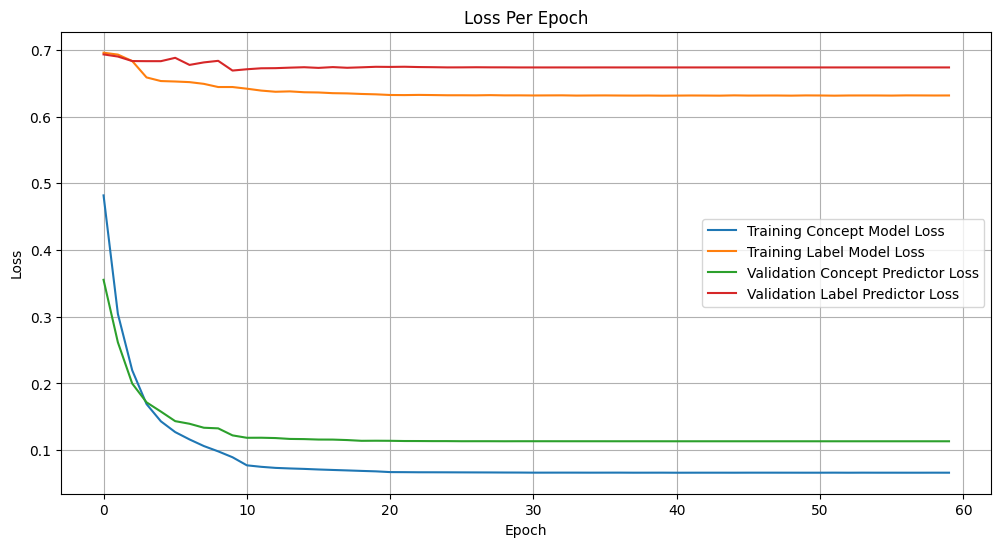

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(epochs_count, x_to_c_loss_values, label='Training Concept Model Loss')
plt.plot(epochs_count, c_to_y_loss_values, label='Training Label Model Loss')
plt.plot(epochs_count, x_to_c_val_loss_values, label='Validation Concept Predictor Loss')
plt.plot(epochs_count, c_to_y_val_loss_values, label='Validation Label Predictor Loss')
plt.title('Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

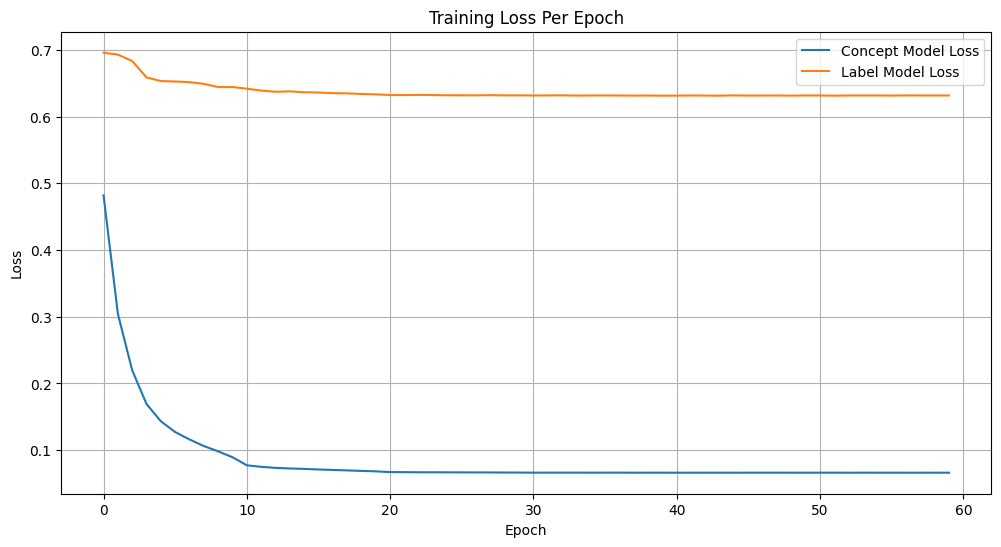

In [8]:
# Training loss
plt.figure(figsize=(12, 6))
plt.plot(epochs_count, x_to_c_loss_values, label='Concept Model Loss')
plt.plot(epochs_count, c_to_y_loss_values, label='Label Model Loss')
plt.title('Training Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

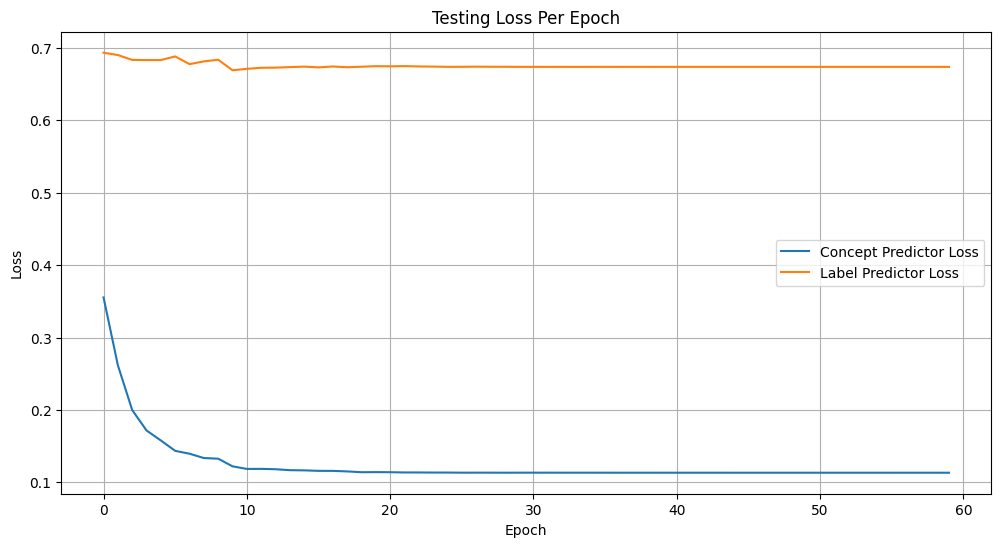

In [9]:
# Testing loss
plt.figure(figsize=(12, 6))
plt.plot(epochs_count, x_to_c_val_loss_values, label='Concept Predictor Loss')
plt.plot(epochs_count, c_to_y_val_loss_values, label='Label Predictor Loss')
plt.title('Testing Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Validation Evaluation

In [10]:
# Concept Predictor Evaluation
def evaluate_concept_predictor(ground_truth_c, x_to_c_predictions, concept_labels):
    results = []
    for i, label in enumerate(concept_labels):
        true_values = np.concatenate([c[:, i].numpy() for c in ground_truth_c])
        predicted_values = np.concatenate([c[:, i] for c in x_to_c_predictions])

        predicted_classes = (predicted_values > 0.5).astype(int)  # Convert probabilities to binary classes

        precision = precision_score(true_values, predicted_classes, zero_division=0)
        recall = recall_score(true_values, predicted_classes, zero_division=0)
        f1 = f1_score(true_values, predicted_classes, zero_division=0)
        accuracy = accuracy_score(true_values, predicted_classes)

        results.append({
            "Label": label,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
            "Accuracy": accuracy
        })
    return pd.DataFrame(results)

In [11]:
# Get concept labels from the data processor
concept_labels = data_processor.get_concepts()

# Evaluation
concept_predictor_results = evaluate_concept_predictor(ground_truth_val_c, x_to_c_val_predictions, concept_labels)
print("Validation Concept Predictor Results:")
print(concept_predictor_results)

Validation Concept Predictor Results:
                   Label  Precision    Recall  F1 Score  Accuracy
0              c_rsp_mod   0.961561  0.978328  0.969872  0.954527
1              c_rsp_svr   0.998725  0.955081  0.976416  0.990658
2             c_vent_low   0.995569  0.992673  0.994119  0.991358
3        c_vent_moderate   0.998416  0.972531  0.985303  0.996132
4            c_vent_high   0.998761  1.000000  0.999380  0.998765
5    c_max_renf_moderate   0.909091  0.744361  0.818520  0.891605
6      c_max_renf_severe   0.907981  0.884505  0.896089  0.906296
7    c_avg_renf_moderate   0.502336  0.127976  0.203985  0.930947
8      c_avg_renf_severe   0.671049  0.731667  0.700048  0.922593
9   c_max_respf_moderate   0.852437  0.539167  0.660541  0.972634
10    c_max_respf_severe   0.974860  0.997143  0.985876  0.972840
11  c_avg_respf_moderate   0.786610  0.765120  0.775716  0.894033
12    c_avg_respf_severe   0.927450  0.924188  0.925817  0.887366
13   c_max_cnsf_moderate   0.847222  0

In [12]:
# Label Predictor Evaluation
def evaluate_label_predictor(ground_truth_y, c_to_y_predictions):
    # Ensure all elements are tensors
    ground_truth_y = [torch.tensor(gy) if not isinstance(gy, torch.Tensor) else gy for gy in ground_truth_y]
    c_to_y_predictions = [torch.tensor(py) if not isinstance(py, torch.Tensor) else py for py in c_to_y_predictions]

    true_values = torch.cat(ground_truth_y).numpy()
    predicted_values = torch.cat(c_to_y_predictions).squeeze().numpy()

    predicted_classes = (predicted_values > 0.5).astype(int)  # Convert probabilities to binary classes

    precision = precision_score(true_values, predicted_classes)
    recall = recall_score(true_values, predicted_classes)
    f1 = f1_score(true_values, predicted_classes)
    auc = roc_auc_score(true_values, predicted_classes)
    accuracy = accuracy_score(true_values, predicted_classes)

    results = {"Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "AUC": auc,
        "Accuracy": accuracy}

    index = pd.Index(["Metrics"])
    return pd.DataFrame(results, index=index)

In [13]:
# Evaluation
print("Validation Label Predictor Results:")
label_predictor_results = evaluate_label_predictor(ground_truth_val_y, c_to_y_val_predictions)
print(label_predictor_results)

Validation Label Predictor Results:
         Precision    Recall  F1 Score       AUC  Accuracy
Metrics   0.614321  0.559649  0.585712  0.592495   0.59144


# Testing Evaluation

In [14]:
def test_model(x_to_c, c_to_y, test_loader):
    x_to_c.eval()  # Set the concept predictor model to evaluation mode
    c_to_y.eval()  # Set the label predictor model to evaluation mode
    criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for classification

    running_x_to_c_test_loss, running_c_to_y_test_loss = 0.0, 0.0
    total_test_samples = 0
    ground_truth_test_c, ground_truth_test_y = [], []
    x_to_c_test_predictions, c_to_y_test_predictions = [], []

    with torch.no_grad():
        for x, c, y in test_loader:
            # GPU
            x, c, y = x.to(device), c.to(device), y.to(device)

            # Ground truth array
            ground_truth_test_c.append(c.cpu())
            ground_truth_test_y.append(y.cpu())

            # Forward pass through x_to_c
            x = x.to(x_to_c.layer1.weight.dtype)  # ensure data type of input tensor x matches data type of weights of the first linear layer
            predicted_c = x_to_c(x)
            x_to_c_test_predictions.append(predicted_c.detach().cpu().numpy())
            c_loss = criterion(predicted_c, c.float())

            # Accumulate x_to_c loss for testing
            running_x_to_c_test_loss += c_loss.item()

            # Forward pass through c_to_y
            predicted_c_detached = predicted_c.detach()  # Detach the predicted_c tensor
            predicted_y = c_to_y(predicted_c_detached)
            c_to_y_test_predictions.append(predicted_y.detach().cpu().numpy())
            y_loss = criterion(predicted_y, y.unsqueeze(1).float())

            # Accumulate c_to_y loss for testing
            running_c_to_y_test_loss += y_loss.item()
            total_test_samples += len(y)

    print(f'Test Concept Predictor Loss: {running_x_to_c_test_loss / len(test_loader):.4f}')
    print(f'Test Label Predictor Loss: {running_c_to_y_test_loss / len(test_loader):.4f}')

    return ground_truth_test_c, ground_truth_test_y, x_to_c_test_predictions, c_to_y_test_predictions

In [15]:
# Call the test function and print the results
ground_truth_test_c, ground_truth_test_y, x_to_c_test_predictions, c_to_y_test_predictions = test_model(x_to_c, c_to_y, test_loader)

Test Concept Predictor Loss: 0.1087
Test Label Predictor Loss: 0.6500


In [16]:
# Evaluate and print test results for the concept predictor
concept_test_results = evaluate_concept_predictor(ground_truth_test_c, x_to_c_test_predictions, concept_labels)
print("Test Concept Predictor Results:")
print(concept_test_results)

Test Concept Predictor Results:
                   Label  Precision    Recall  F1 Score  Accuracy
0              c_rsp_mod   0.990132  0.961661  0.975689  0.962871
1              c_rsp_svr   1.000000  1.000000  1.000000  1.000000
2             c_vent_low   0.996774  0.996774  0.996774  0.995050
3        c_vent_moderate   1.000000  0.962264  0.980769  0.995050
4            c_vent_high   0.997525  1.000000  0.998761  0.997525
5    c_max_renf_moderate   0.931034  0.812030  0.867470  0.918317
6      c_max_renf_severe   0.912371  0.903061  0.907692  0.910891
7    c_avg_renf_moderate   0.727273  0.181818  0.290909  0.903465
8      c_avg_renf_severe   0.728814  0.767857  0.747826  0.928218
9   c_max_respf_moderate   0.846154  0.647059  0.733333  0.980198
10    c_max_respf_severe   0.984694  0.997416  0.991014  0.982673
11  c_avg_respf_moderate   0.928571  0.819820  0.870813  0.933168
12    c_avg_respf_severe   0.937294  0.975945  0.956229  0.935644
13   c_max_cnsf_moderate   0.823944  0.82978

In [17]:
# Evaluate and print test results for the label predictor
label_test_results = evaluate_label_predictor(ground_truth_test_y, c_to_y_test_predictions)
print("Test Label Predictor Results:")
print(label_test_results)

Test Label Predictor Results:
         Precision    Recall  F1 Score       AUC  Accuracy
Metrics   0.557895  0.572973  0.565333  0.594706  0.596535


# Finding Completeness Score

In [18]:
from sklearn.metrics import mutual_info_score
import numpy as np

def compute_mutual_information(true_labels, predicted_values):
    # Convert the predicted values to binary classes
    predicted_classes = (predicted_values > 0.5).astype(int)
    return mutual_info_score(true_labels, predicted_classes)

# Compute mutual information I(y; c)
def compute_I_y_c(ground_truth_val_y, c_to_y_val_predictions):
    true_values = np.concatenate([gy.numpy() for gy in ground_truth_val_y])
    predicted_values = np.concatenate([py.squeeze() for py in c_to_y_val_predictions])
    return compute_mutual_information(true_values, predicted_values)

# Compute mutual information I(y; c, x)
def compute_I_y_c_x(ground_truth_val_y, x_to_c_val_predictions, c_to_y_val_predictions):
    true_values = np.concatenate([gy.numpy() for gy in ground_truth_val_y])

    # Compute mutual information for each concept and label pair
    predicted_concepts = np.concatenate(x_to_c_val_predictions)
    predicted_labels = np.concatenate([py.squeeze() for py in c_to_y_val_predictions])

    combined_predictions = np.column_stack((predicted_concepts, predicted_labels))

    # Flatten combined_predictions to make it 1D
    combined_predictions_flat = combined_predictions.flatten()

    return mutual_info_score(true_values, combined_predictions_flat[:len(true_values)])

# Compute the Completeness Score
def compute_completeness_score(I_y_c, I_y_c_x):
    return I_y_c / I_y_c_x

# Calculate mutual information
I_y_c = compute_I_y_c(ground_truth_val_y, c_to_y_val_predictions)
print(f"Mutual Information I(y; c): {I_y_c}")

I_y_c_x = compute_I_y_c_x(ground_truth_val_y, x_to_c_val_predictions, c_to_y_val_predictions)
print(f"Mutual Information I(y; c, x): {I_y_c_x}")

# Calculate completeness score
completeness_score = compute_completeness_score(I_y_c, I_y_c_x)
print(f"Completeness Score: {completeness_score}")


Mutual Information I(y; c): 0.017263981247328697
Mutual Information I(y; c, x): 0.6818040950228228
Completeness Score: 0.02532102897790721


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received binary values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


# Model Weights


In [19]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Function to get weights contribution from each feature to each concept
def get_feature_to_concept_weights(model, feature_names, concept_names):
    layer1_weights = model.layer1.weight.data.cpu().numpy()
    contributions = np.zeros((len(concept_names), len(feature_names)))

    for i, feature in enumerate(feature_names):
        for j, concept in enumerate(concept_names):
            contributions[j, i] = layer1_weights[j, i]

    return pd.DataFrame(contributions, index=concept_names, columns=feature_names)

# Function to get weights contribution from each concept to final label
def get_concept_to_label_weights(model, concept_names, label_names):
    output_weights = model.output_layer.weight.data.cpu().numpy()
    contributions = np.zeros((len(label_names), len(concept_names)))

    for i, concept in enumerate(concept_names):
        for j, label in enumerate(label_names):
            contributions[j, i] = output_weights[j, i]

    return pd.DataFrame(contributions, index=label_names, columns=concept_names)

# Get feature and concept names
feature_names = data_processor.get_features()
concept_names = data_processor.get_concepts()
label_names = ['ARDS']

# Get weights contributions
feature_to_concept_contributions = get_feature_to_concept_weights(x_to_c, feature_names, concept_names)
concept_to_label_contributions = get_concept_to_label_weights(c_to_y, concept_names, label_names)

# Get weights contributions
feature_to_concept_contributions = get_feature_to_concept_weights(x_to_c, feature_names, concept_names)
concept_to_label_contributions = get_concept_to_label_weights(c_to_y, concept_names, label_names)

A. Feature to Concept

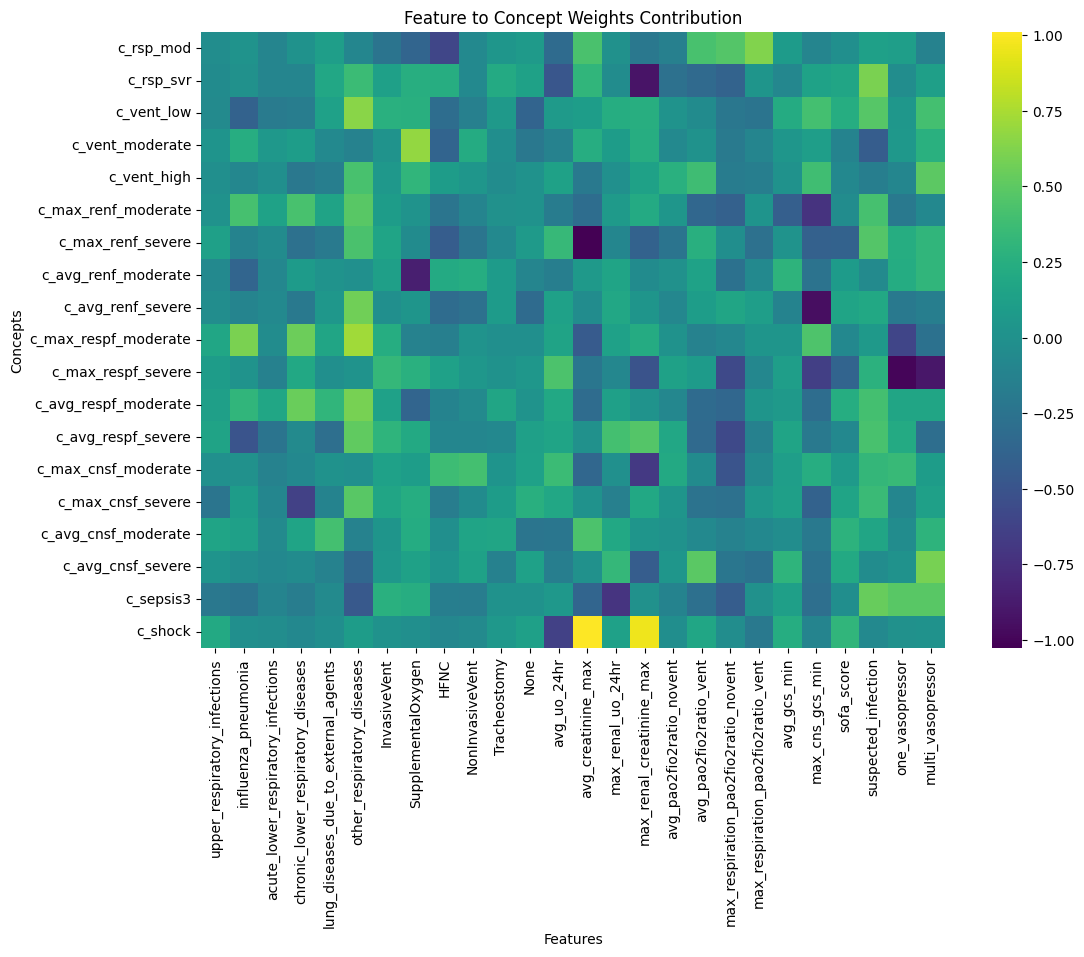

In [20]:
plt.figure(figsize=(12, 8))
sns.heatmap(feature_to_concept_contributions, cmap='viridis', cbar=True)
plt.title('Feature to Concept Weights Contribution')
plt.xlabel('Features')
plt.ylabel('Concepts')
plt.show()

print("Feature to Concept Weights Contribution:")
print(feature_to_concept_contributions)

B. Concept to Label

Feature to Concept Weights Contribution:
                      upper_respiratory_infections  influenza_pneumonia  \
c_rsp_mod                                -0.032095             0.016334   
c_rsp_svr                                -0.052591            -0.003163   
c_vent_low                               -0.060581            -0.391477   
c_vent_moderate                           0.030536             0.244009   
c_vent_high                              -0.019258            -0.082997   
c_max_renf_moderate                       0.005049             0.411055   
c_max_renf_severe                         0.126671            -0.113927   
c_avg_renf_moderate                      -0.065786            -0.371174   
c_avg_renf_severe                        -0.036595            -0.109429   
c_max_respf_moderate                      0.176457             0.601089   
c_max_respf_severe                        0.093238             0.022146   
c_avg_respf_moderate                      0.118564         

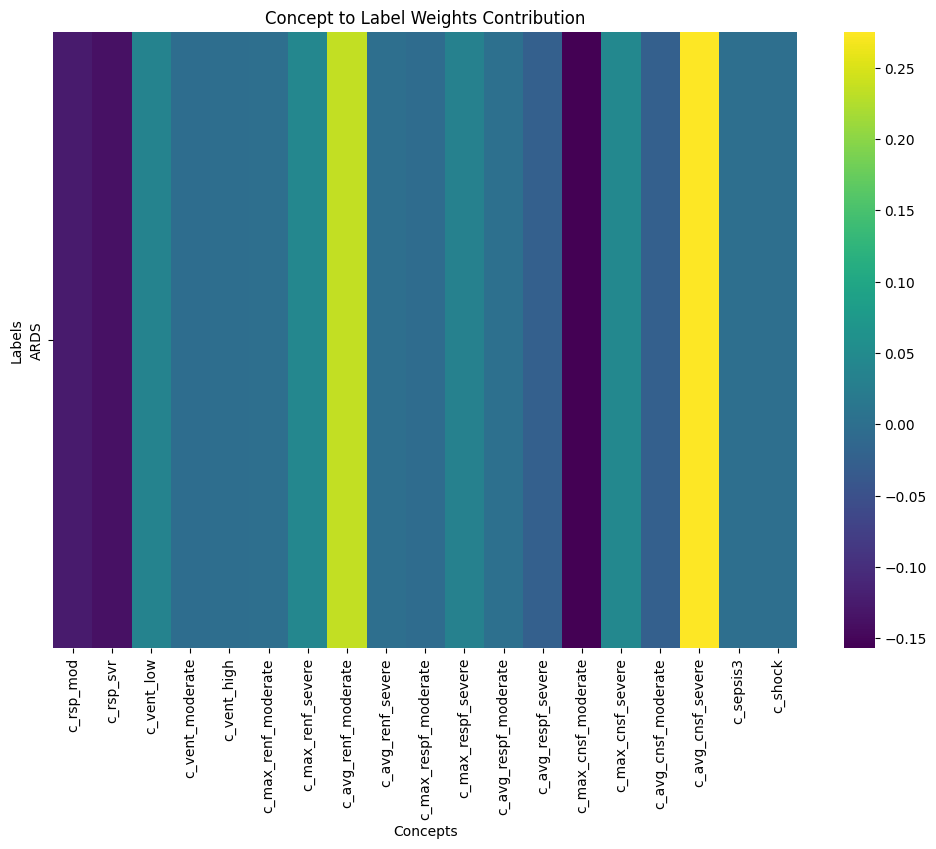

Concept to Label Weights Contribution:
      c_rsp_mod  c_rsp_svr  c_vent_low  c_vent_moderate  c_vent_high  \
ARDS  -0.125822  -0.136803    0.036093        -0.003987    -0.002889   

      c_max_renf_moderate  c_max_renf_severe  c_avg_renf_moderate  \
ARDS            -0.000028           0.042583             0.235297   

      c_avg_renf_severe  c_max_respf_moderate  c_max_respf_severe  \
ARDS           0.000001             -0.006467            0.031028   

      c_avg_respf_moderate  c_avg_respf_severe  c_max_cnsf_moderate  \
ARDS              0.000924            -0.02678            -0.156649   

      c_max_cnsf_severe  c_avg_cnsf_moderate  c_avg_cnsf_severe  c_sepsis3  \
ARDS           0.044358            -0.026292           0.275115  -0.000476   

       c_shock  
ARDS -0.000822  


In [21]:
plt.figure(figsize=(12, 8))
sns.heatmap(concept_to_label_contributions, cmap='viridis', cbar=True)
plt.title('Concept to Label Weights Contribution')
plt.xlabel('Concepts')
plt.ylabel('Labels')
plt.show()

print("Concept to Label Weights Contribution:")
print(concept_to_label_contributions)

C. Combined Feature-Concept Pair to Label

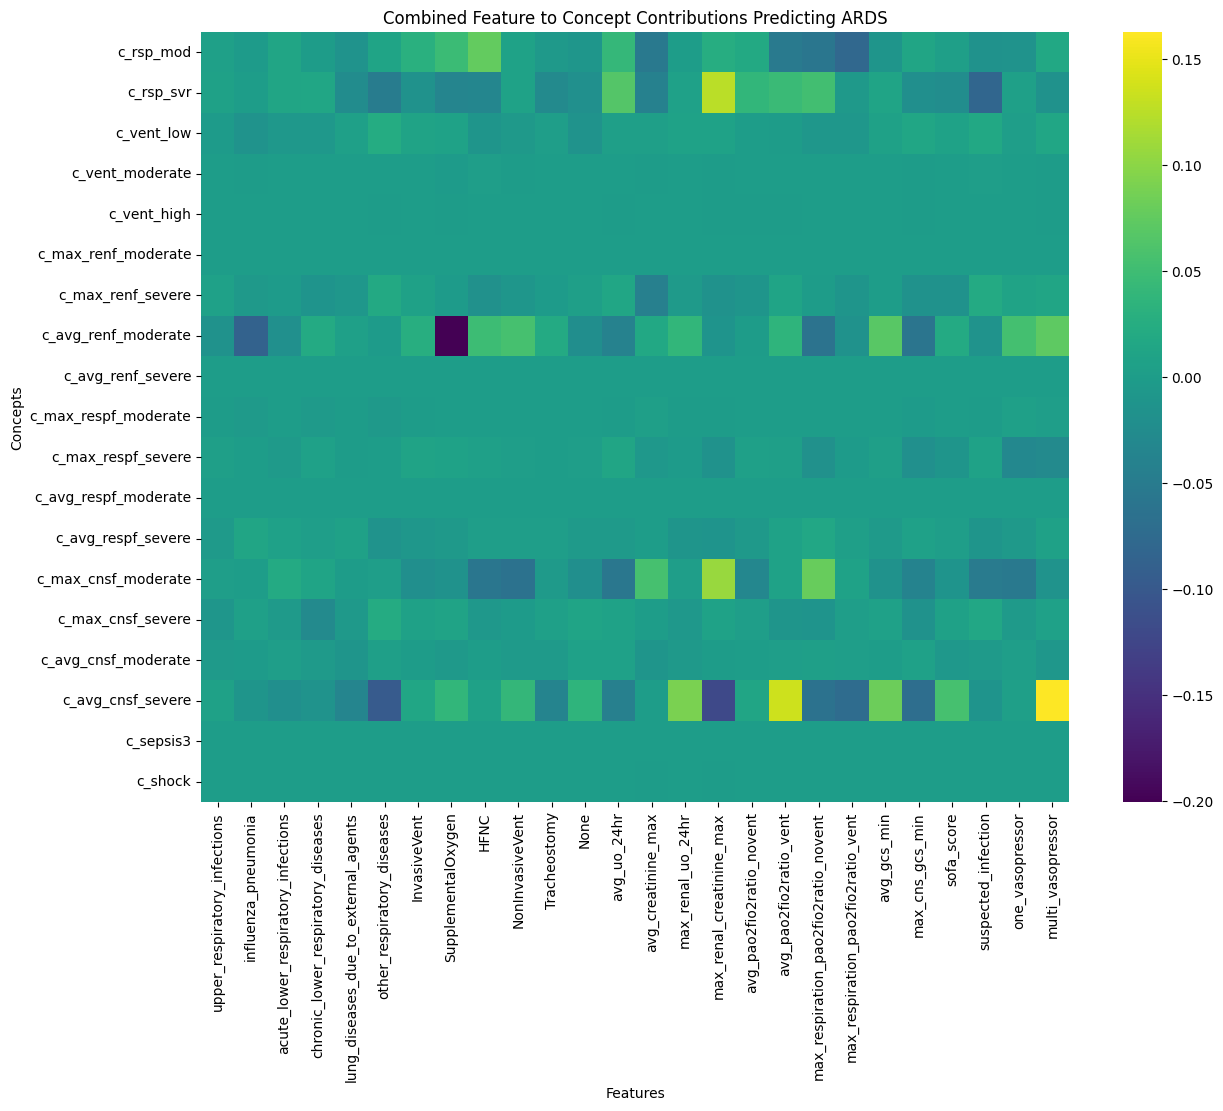

Combined Contributions Predicting ARDS:
                      upper_respiratory_infections  influenza_pneumonia  \
c_rsp_mod                             4.038214e-03        -2.055117e-03   
c_rsp_svr                             7.194668e-03         4.327367e-04   
c_vent_low                           -2.186559e-03        -1.412955e-02   
c_vent_moderate                      -1.217445e-04        -9.728476e-04   
c_vent_high                           5.563967e-05         2.397926e-04   
c_max_renf_moderate                  -1.426313e-07        -1.161108e-05   
c_max_renf_severe                     5.394102e-03        -4.851394e-03   
c_avg_renf_moderate                  -1.547923e-02        -8.733607e-02   
c_avg_renf_severe                    -4.376005e-08        -1.308559e-07   
c_max_respf_moderate                 -1.141213e-03        -3.887460e-03   
c_max_respf_severe                    2.892964e-03         6.871540e-04   
c_avg_respf_moderate                  1.095607e-04         2

In [22]:
# Extract the weights for the label 'ARDS'
concept_to_label_weights = concept_to_label_contributions.loc[label_names[0]].values

# Reshape concept_to_label_weights for element-wise multiplication
concept_to_label_weights = concept_to_label_weights.reshape(-1, 1)

# Calculate the combined contributions by element-wise multiplication
combined_contributions = feature_to_concept_contributions.values * concept_to_label_weights

# Create a DataFrame for the combined contributions
combined_df = pd.DataFrame(combined_contributions, index=concept_names, columns=feature_names)

# Plotting the combined heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(combined_df, cmap='viridis', cbar=True, fmt=".2f")
plt.title('Combined Feature to Concept Contributions Predicting ARDS')
plt.xlabel('Features')
plt.ylabel('Concepts')
plt.show()

print("Combined Contributions Predicting ARDS:")
print(combined_df)

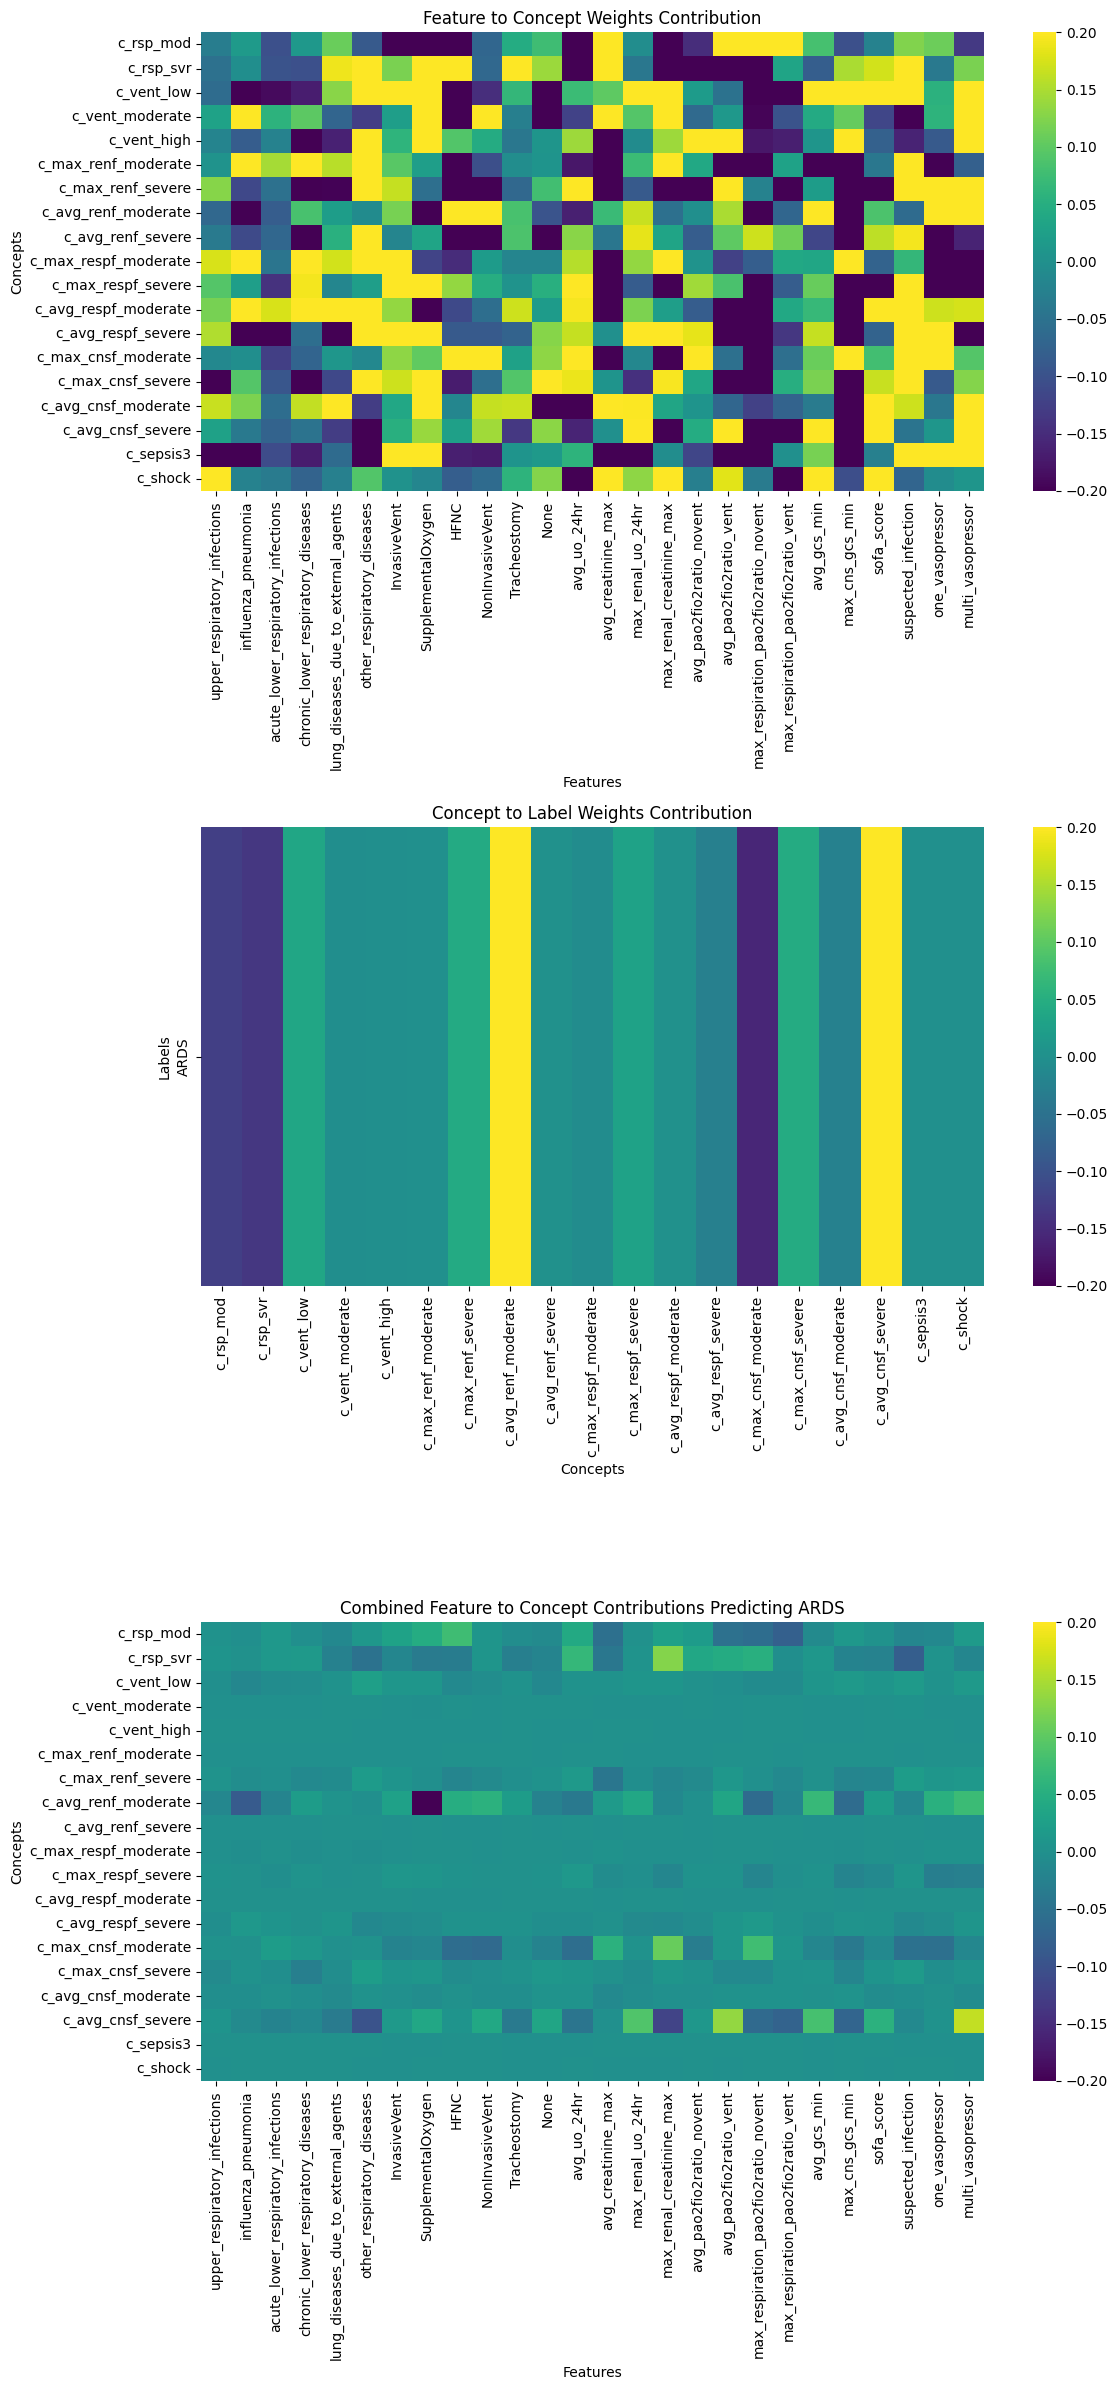

In [23]:
# Define the fixed scale for the heatmaps
fixed_vmin = -0.2  # Set your desired minimum value
fixed_vmax = 0.2   # Set your desired maximum value

# Create a figure with three subplots arranged in a column
fig, axes = plt.subplots(nrows=3, figsize=(12, 24))

# Plotting the feature to concept weight
sns.heatmap(feature_to_concept_contributions, cmap='viridis', cbar=True, vmin=fixed_vmin, vmax=fixed_vmax, ax=axes[0])
axes[0].set_title('Feature to Concept Weights Contribution')
axes[0].set_xlabel('Features')
axes[0].set_ylabel('Concepts')

# Plotting the concept to label weight
sns.heatmap(concept_to_label_contributions, cmap='viridis', cbar=True, vmin=fixed_vmin, vmax=fixed_vmax, ax=axes[1])
axes[1].set_title('Concept to Label Weights Contribution')
axes[1].set_xlabel('Concepts')
axes[1].set_ylabel('Labels')

# Plotting the combined heatmap
sns.heatmap(combined_df, cmap='viridis', cbar=True, fmt=".2f", vmin=fixed_vmin, vmax=fixed_vmax, ax=axes[2])
axes[2].set_title('Combined Feature to Concept Contributions Predicting ARDS')
axes[2].set_xlabel('Features')
axes[2].set_ylabel('Concepts')

# Adjust layout
plt.tight_layout()

# Save the figure as a single image
plt.savefig('ards-seq-heatmaps.png')

# Show the figure
plt.show()